# Import packages

In [42]:
import pandas as pd
import re 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data wrangling

In [102]:
df = pd.read_csv("exoneration_mar22_2024.csv")

In [103]:
df.head()

,Last Name,First Name,Age,Race,Sex,State,County,Tags,Worst Crime Display,Sentence,...,Posting Date,OM Tags,F/MFE,FC,ILD,P/FA,DNA,MWID,OM,Date of Crime Year
0,Abbitt,Joseph,31.0,Black,Male,North Carolina,Forsyth,CV;#IO;#SA,Child Sex Abuse,Life,...,9/1/2011,NaN,NaN,NaN,NaN,NaN,DNA,MWID,NaN,"1,991"
1,Abbott,Cinque,19.0,Black,Male,Illinois,Cook,CIU;#IO;#NC;#P,Drug Possession or Sale,Probation,...,2/14/2022,OF;#WH;#NW,NaN,NaN,NaN,P/FA,NaN,NaN,OM,"2,008"
2,Abdal,Warith Habib,43.0,Black,Male,New York,Erie,IO;#SA,Sexual Assault,20 to Life,...,8/29/2011,OF;#WH;#NW;#WT,F/MFE,NaN,NaN,NaN,DNA,MWID,OM,"1,982"
3,Abernathy,Christopher,17.0,White,Male,Illinois,Cook,CIU;#CV;#H;#IO;#JV;#SA,Murder,Life without parole,...,2/13/2015,OF;#WH;#NW;#INT,NaN,FC,NaN,P/FA,DNA,NaN,OM,"1,984"
4,Abney,Quentin,32.0,Black,Male,New York,New York,CV,Robbery,20 to Life,...,5/13/2019,NaN,NaN,NaN,NaN,NaN,NaN,MWID,NaN,"2,005"


In [8]:
print(len(df))

3486


In [117]:

def get_decade(year):
    return (year // 10) * 10
    
def clean_yr(x):
    x = x.replace(",", "")
    return int(x) 
    
def extract_time(sentence):
    match = re.search(r'(\d+)\s*(year|month|day)s?', sentence, re.IGNORECASE)
    if match:
        time_value, unit = int(match.group(1)), match.group(2).lower()
        if unit.startswith('month'):
            time_value = time_value / 12  # Convert months to years
        elif unit.startswith('day'):
            time_value = time_value / 365  # Convert days to years
        if time_value <= 70:
            return time_value
        else:
            return np.NaN

    if any(term in sentence for term in ['Life', 'life', 'Probation', 'Not sentenced', 'Death']):
        return np.nan

    return np.nan  # Return NaN if no time unit is found or if specific terms are present

# Apply the updated function to the Sentence column of the dataset
df = pd.read_csv("exoneration_mar22_2024.csv")
df['years'] = df['Sentence'].apply(extract_time)

df['sentence_date'] = df['Date of Crime Year'].apply(clean_yr)
df['exoneration_date'] = df['Exonerated'].astype(int)
df['diff'] = df['exoneration_date'] - df['sentence_date'] 
df['sentence_decade'] = df['sentence_date'].apply(get_decade)
df['exoneration_decade'] = df['exoneration_date'].apply(get_decade)

df['worst_crime'] = df['Worst Crime Display']

df = df.dropna(subset=['years', 'sentence_date'])



# Descriptives

<Axes: xlabel='sentence_date', ylabel='Count'>

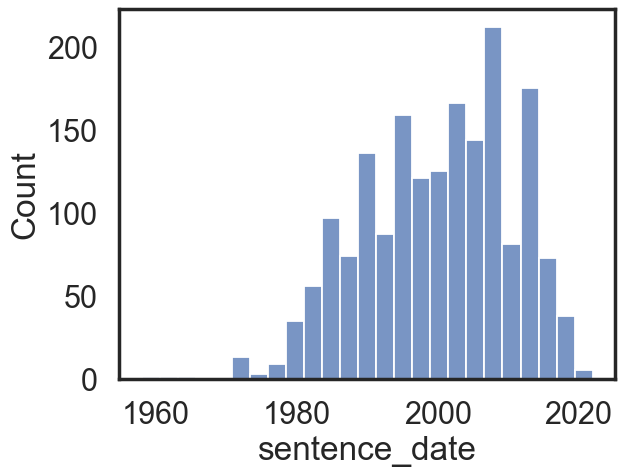

In [85]:
sns.histplot(df['sentence_date'])

<Axes: xlabel='diff', ylabel='Count'>

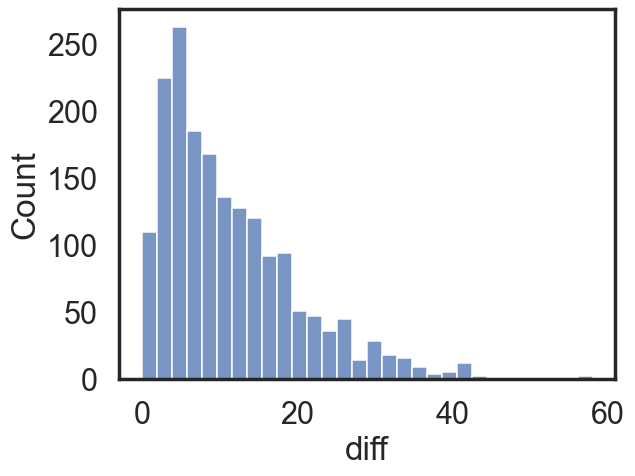

In [105]:
sns.histplot(df['diff'])

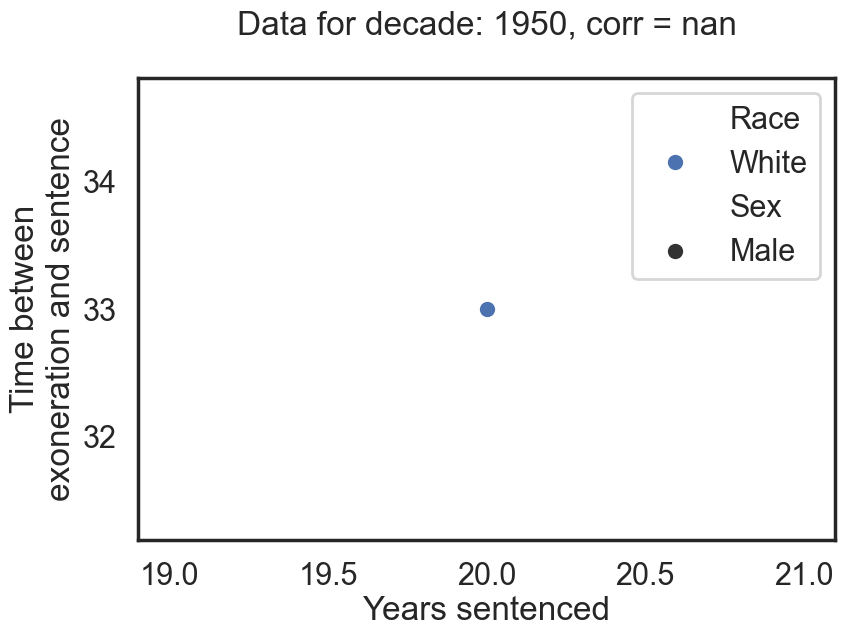

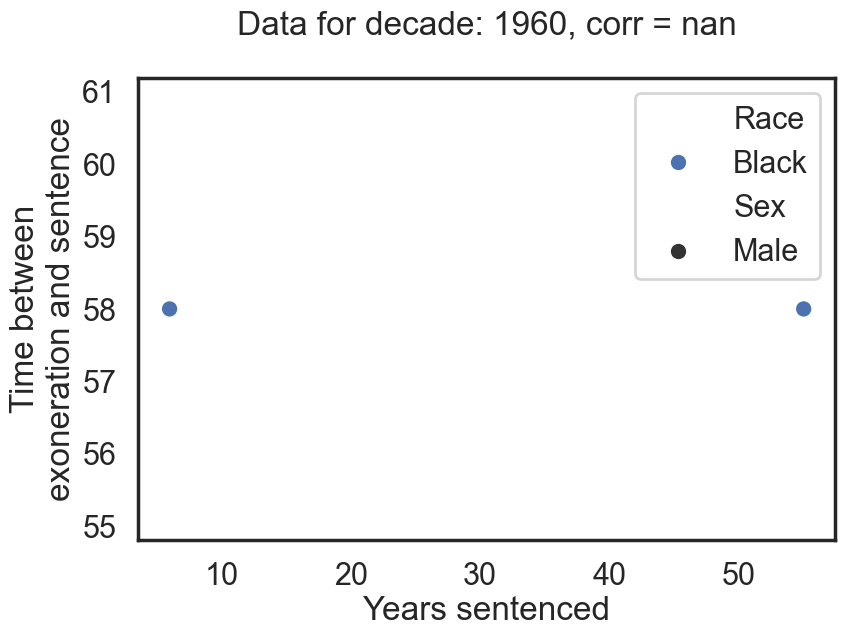

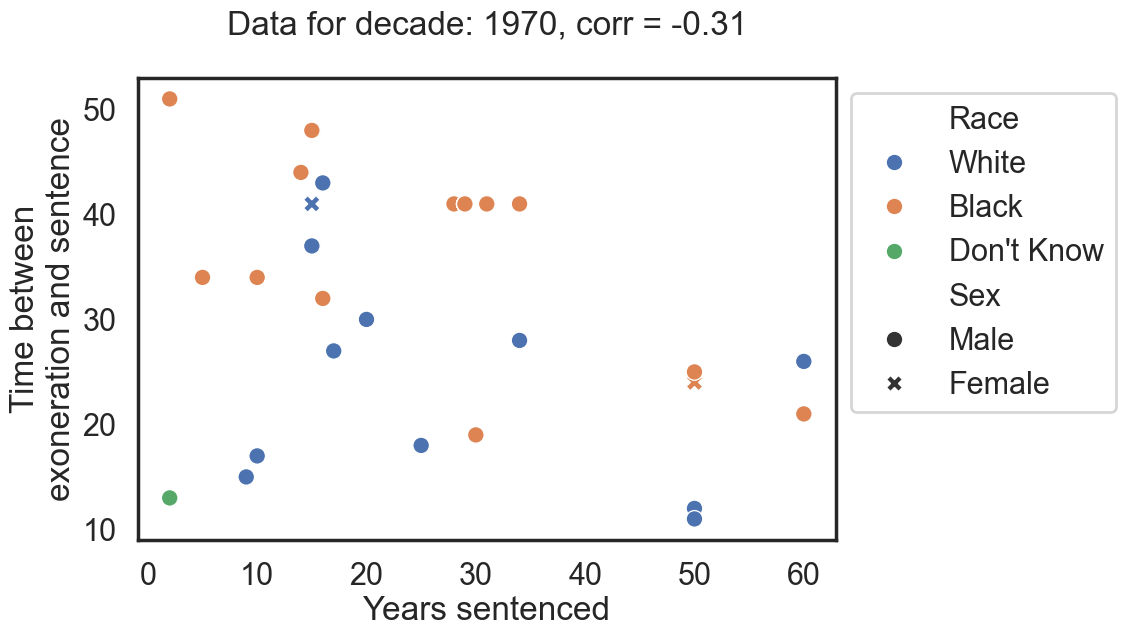

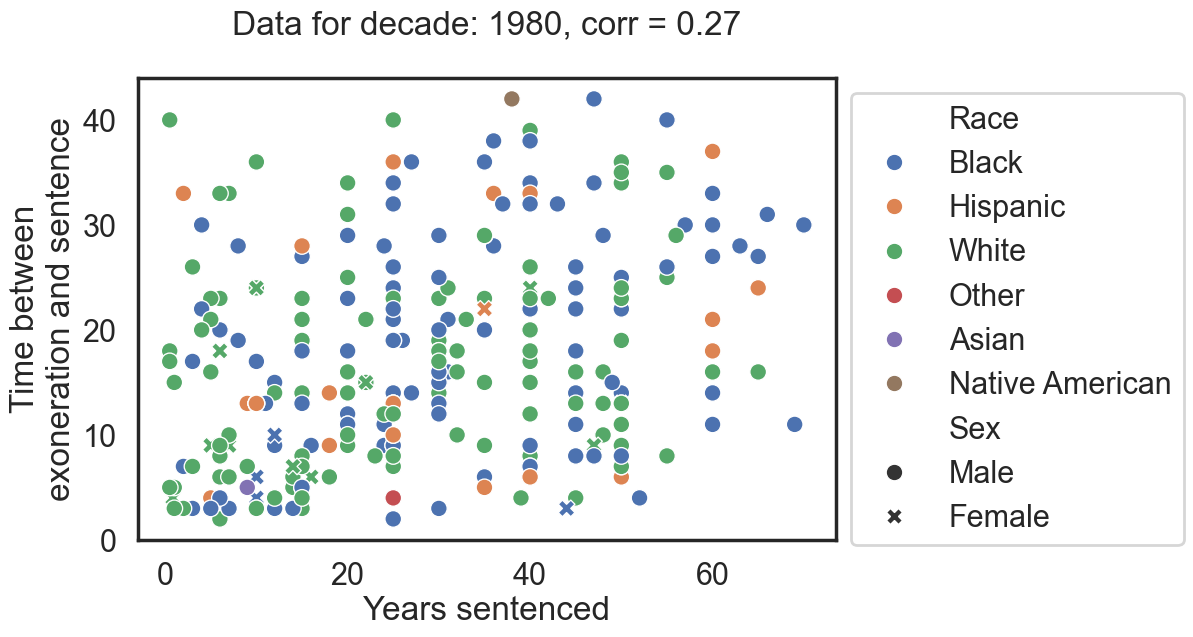

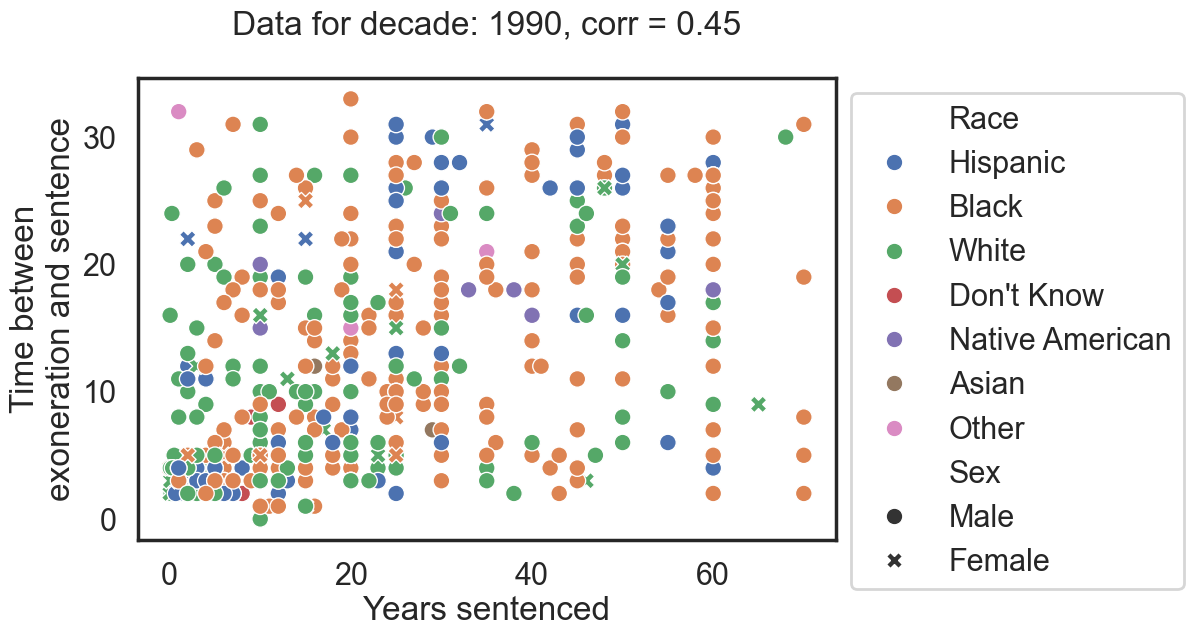

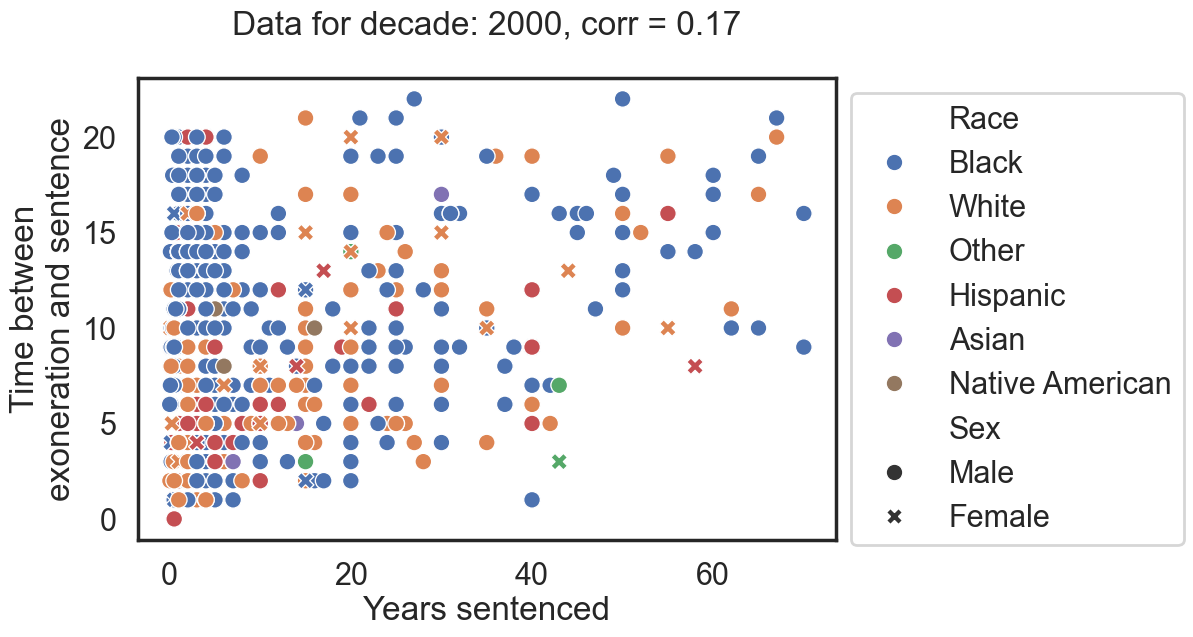

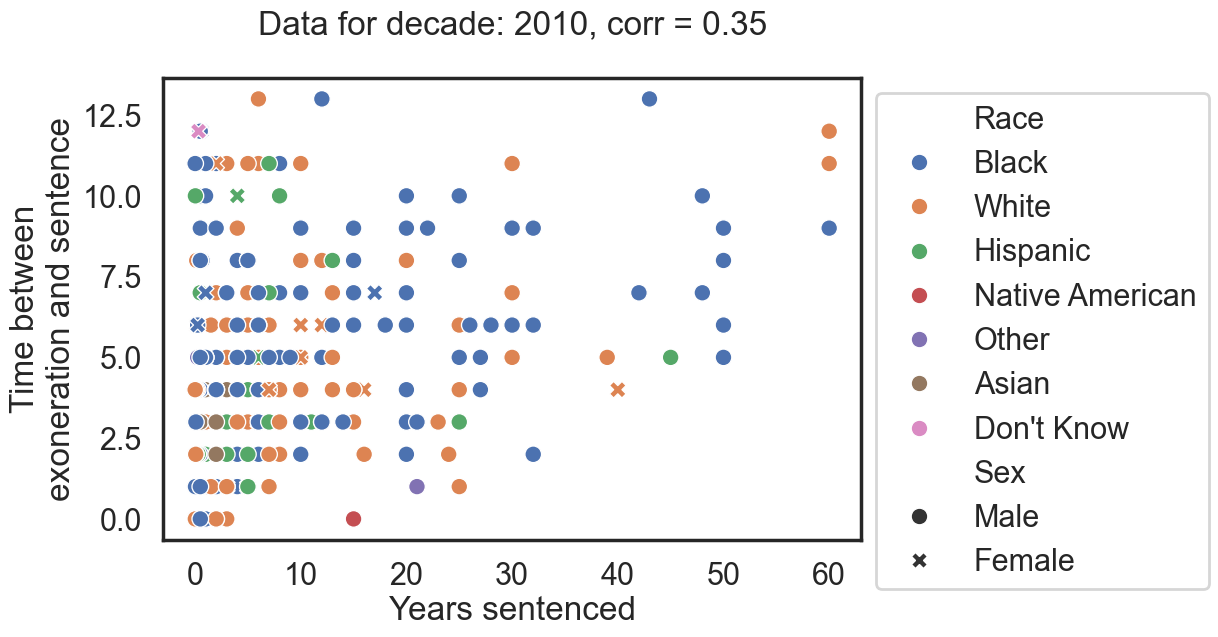

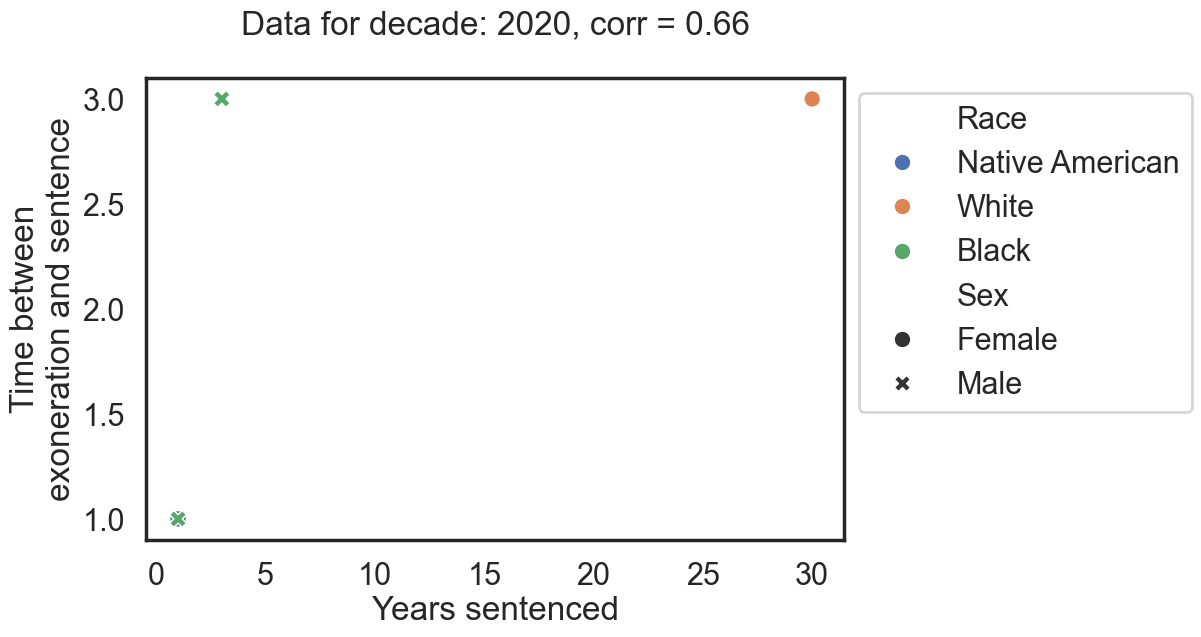

In [106]:
for decade in sorted(list(df['sentence_decade'].unique())):
    plt.figure(figsize=(9,6))
    tdf = df[df['sentence_decade'] == decade]
    sns.scatterplot(data=tdf, x='years', y='diff', hue='Race', style='Sex')
    plt.title(f"Data for decade: {decade}, corr = {np.round(tdf[['years', 'diff']].corr().reset_index()['years'].iloc[1],2)}\n")
    plt.xlabel("Years sentenced")
    plt.ylabel("Time between\nexoneration and sentence")
    plt.legend(bbox_to_anchor=[1,1])
    plt.show()


Text(0.5, 1.0, 'Time between sentence date and exoneration\n')

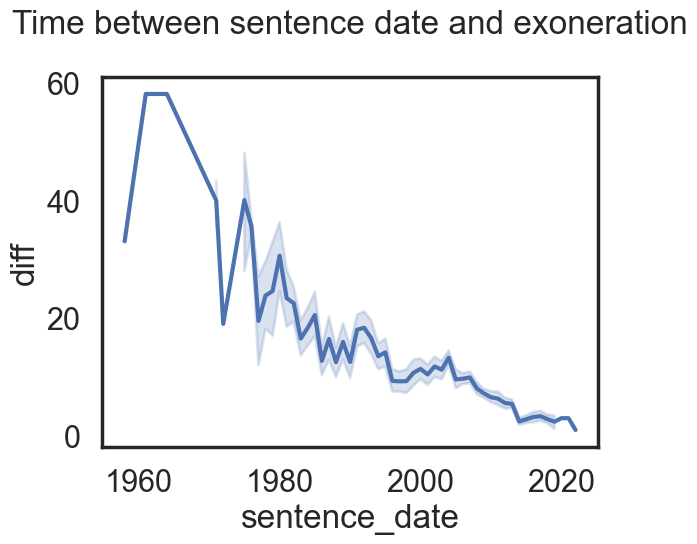

In [108]:
sns.lineplot(data=df, x='sentence_date', y='diff')
plt.title("Time between sentence date and exoneration\n")

# OLS

In [120]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='diff ~ sentence_date + years + Age + C(Sex) + C(Race) + C(worst_crime) + C(County)', data=df).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     5.727
Date:                Fri, 22 Mar 2024   Prob (F-statistic):          6.56e-136
Time:                        13:58:33   Log-Likelihood:                -5410.5
No. Observations:                1768   AIC:                         1.174e+04
Df Residuals:                    1309   BIC:                         1.425e+04
Df Model:                         458                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------